## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from random import sample
from keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
67812,00016758_000.png,No Finding,0,16758,37,F,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00016758_000.png
34942,00009223_000.png,No Finding,0,9223,20,F,PA,2048,2500,0.168,0.168,NaN,/data/images_004/images/00009223_000.png
87774,00021703_000.png,Atelectasis,0,21703,24,M,PA,3024,2456,0.139,0.139,NaN,/data/images_010/images/00021703_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_diseases = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda all_findings: all_findings.split('|')).tolist())))
all_diseases = [x for x in all_diseases if len(x)>0]
print('All Labels ({}): {}'.format(len(all_diseases), all_diseases))

for c_disease in all_diseases: 
    if len(c_disease)>1: # leave out empty labels
        all_xray_df[c_disease] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_disease in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
36995,00009736_012.png,Effusion|Pneumothorax,12,9736,66,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58492,00014465_007.png,No Finding,7,14465,63,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46729,00011925_054.png,Consolidation|Infiltration,54,11925,54,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda row: 'Present' if row['Pneumonia'] else 'Not Present', axis = 1)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
93666,00023557_000.png,No Finding,0,23557,18,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Not Present
5462,00001460_001.png,Infiltration,1,1460,40,F,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Present
34842,00009198_001.png,Mass,1,9198,50,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Not Present


## Create your training and testing data:

In [5]:
def create_splits():
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = skl.train_test_split(all_xray_df, test_size = 0.2, stratify = all_xray_df['Pneumonia'])
    
    # The training data should be balanced, 50% positive, 50% negative.
    # In this case, we know that the number of negative cases are higher than the positive cases, so
    # we remove extra negative samples
    pos_indices = train_data[train_data.Pneumonia == 1].index.tolist()
    neg_indices = train_data[train_data.Pneumonia == 0].index.tolist()
    
    neg_sample = sample(neg_indices, len(pos_indices))
    train_data = train_data.loc[pos_indices + neg_sample]
    
    # The validation data should have the same proportion of positive cases as the actual clinical data
    # Since the data we have was not collected for pneumonia specifically, we have to modify the validation
    # set accordingly. Here, we assume that the prevalence of pneumonia in this setting is 20%.
    
    pos_indices = val_data[val_data.Pneumonia == 1].index.tolist()
    neg_indices = val_data[val_data.Pneumonia == 0].index.tolist()
    
    neg_sample = sample(neg_indices, 4 * len(pos_indices))
    val_data = val_data.loc[pos_indices + neg_sample]
    
    return train_data, val_data

train_data, val_data = create_splits()

In [6]:
train_data['Pneumonia'].sum()/len(train_data)

0.5

In [7]:
val_data['Pneumonia'].sum()/len(val_data)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                horizontal_flip = True,
                                vertical_flip = False, 
                                height_shift_range = 0.2,
                                width_shift_range = 0.2, 
                                rotation_range = 30, 
                                shear_range = 0.2,
                                zoom_range=0.2)
    
    return my_idg


def make_train_gen():
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
    idg = my_image_augmentation()
    
    train_gen = idg.flow_from_dataframe(dataframe=train_data, 
                                        directory=None, 
                                        x_col = 'path',
                                        y_col = 'pneumonia_class',
                                        class_mode = 'binary',
                                        target_size = (224, 224), 
                                        batch_size = 16)
    
    return train_gen


def make_val_gen():
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                horizontal_flip = False,
                                vertical_flip = False, 
                                height_shift_range = 0.0,
                                width_shift_range = 0.0, 
                                rotation_range = 0, 
                                shear_range = 0.0,
                                zoom_range=0.0)
    
    val_gen = my_idg.flow_from_dataframe(dataframe=val_data, 
                                        directory=None, 
                                        x_col = 'path',
                                        y_col = 'pneumonia_class',
                                        class_mode = 'binary',
                                        target_size = (224, 224), 
                                        batch_size = 16)
    
    return val_gen

train_gen = make_train_gen()
val_gen = make_val_gen()

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [9]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

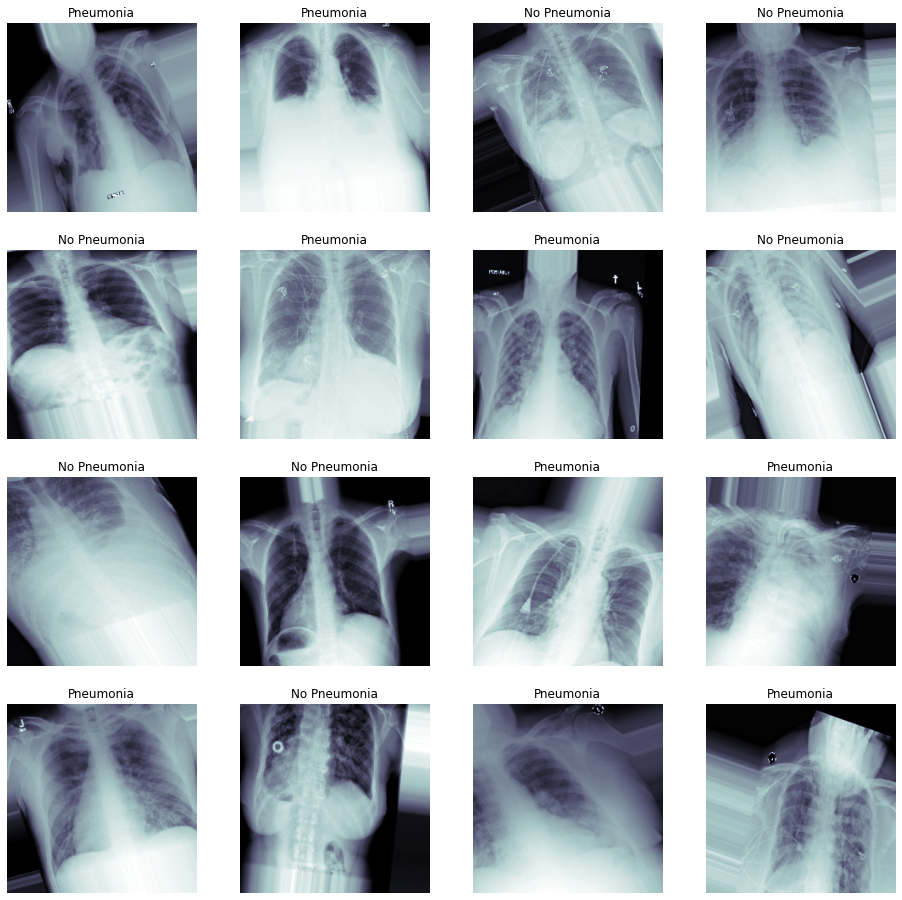

In [10]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [11]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers:
        layer.trainable = False
    
    return vgg_model


In [12]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def build_my_model():
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    my_model.add(load_pretrained_model())
    my_model.add(Flatten())
    my_model.add(Dense(128, activation = 'relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(64, activation = 'relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(32, activation = 'relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(1, activation = 'relu'))
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    optimizer = Adam(lr=1e-6)
    loss = 'binary_crossentropy'
    metrics = [f1_m, precision_m, recall_m]
    
    my_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    
    return my_model

my_model = build_my_model()
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [13]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="f1_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_f1_m', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'max', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_f1_m', 
                       mode= 'max', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [14]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 100, 
                           callbacks = callbacks_list)

Epoch 1/100
144/144 [==============================] - 63s 440ms/step - loss: 2.2881 - f1_m: 0.5222 - precision_m: 0.4881 - recall_m: 0.5966 - val_loss: 0.6351 - val_f1_m: 0.4444 - val_precision_m: 0.5000 - val_recall_m: 0.4000

Epoch 00001: val_f1_m improved from -inf to 0.44444, saving model to f1_my_model.best.hdf5
Epoch 2/100
144/144 [==============================] - 60s 418ms/step - loss: 1.7243 - f1_m: 0.4791 - precision_m: 0.4909 - recall_m: 0.4910 - val_loss: 0.6024 - val_f1_m: 0.2857 - val_precision_m: 0.5000 - val_recall_m: 0.2000

Epoch 00002: val_f1_m did not improve from 0.44444
Epoch 3/100
144/144 [==============================] - 60s 414ms/step - loss: 1.5357 - f1_m: 0.4838 - precision_m: 0.5004 - recall_m: 0.4928 - val_loss: 0.5913 - val_f1_m: 0.3333 - val_precision_m: 1.0000 - val_recall_m: 0.2000

Epoch 00003: val_f1_m did not improve from 0.44444
Epoch 4/100
144/144 [==============================] - 60s 416ms/step - loss: 1.4695 - f1_m: 0.4619 - precision_m: 0.509

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [15]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

16/16 [==============================] - 0s 15ms/step


In [16]:
def plot_auc(t_y, p_y):    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    
    plt.title('AUC')
    
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

## what other performance statistics do you want to include here besides AUC? 

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def plot_f1_threshold_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    thresholds = []
    f1s = []
    
    for t in np.arange(0.0,1,0.001):
        pred = (p_y.reshape(-1)>t)*1.
        f1 = f1_m(np.float64(t_y), np.float64(pred))
        thresholds.append(t)
        f1s.append(f1)
        
    c_ax.plot(thresholds, f1s, label = 'f1 vs threshold')
    c_ax.legend()
    c_ax.set_xlabel('Threshold')
    c_ax.set_ylabel('F1')
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    plt.figure()
    plt.plot(history['loss'], color = 'green', label = "train loss")
    plt.plot(history['val_loss'], color = 'blue', label = 'validation loss')
    plt.plot(history['val_f1_m'], color = 'red', label = "validation_f1")
    plt.legend()
    plt.title("Training Loss on Dataset")
    plt.xlabel("Epoch number")
    plt.ylabel("Loss")
    

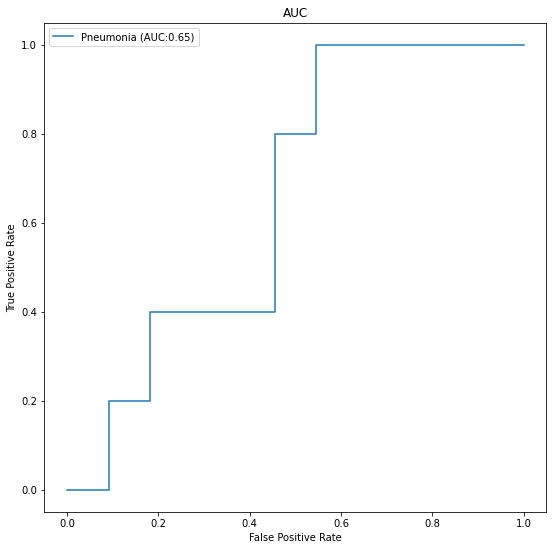

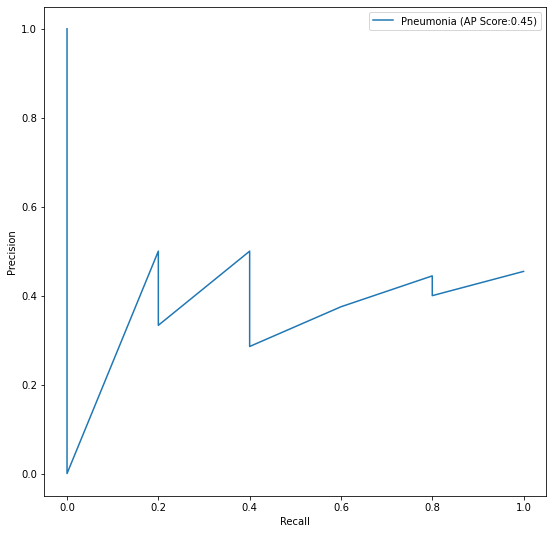

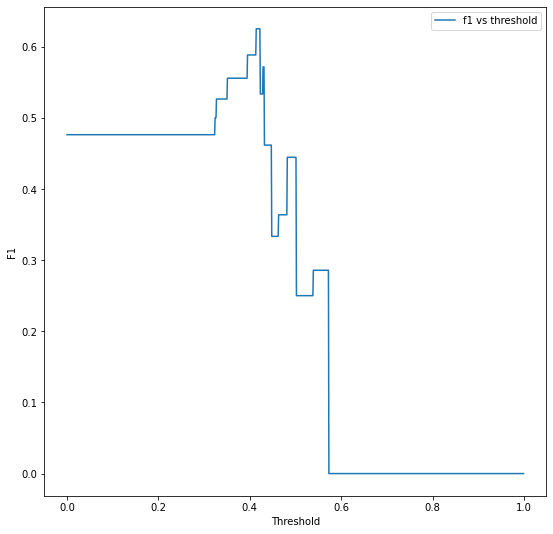

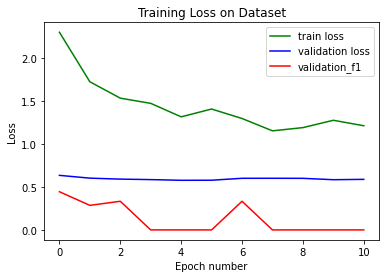

In [17]:
## plot figures

plot_auc(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)
plot_f1_threshold_curve(valY, pred_Y)
plot_history(history.history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [18]:
def optimize_f1(t_y, p_y):
    best_thresh = 0
    best_f1 = 0.
    for t in np.arange(0.0,1,0.001):
        pred = (p_y.reshape(-1)>t)*1.
        f1 = f1_m(np.float64(t_y), np.float64(pred))
        if f1 > best_f1:
            best_thresh = t
            best_f1 = f1
    return best_thresh, best_f1
best_thresh, best_f1 = optimize_f1(valY, pred_Y)
print("Threshold of %.2f gives best f1 at %.4f"%(best_thresh, best_f1))
pred_Y_class = pred_Y > best_thresh
f1_score(valY, pred_Y_class)

Threshold of 0.41 gives best f1 at 0.6250


0.625

In [19]:
test_idg = ImageDataGenerator(rescale=1. / 255.0)
test_gen = test_idg.flow_from_dataframe(dataframe = val_data, 
                                         directory=None, 
                                         x_col = "path",
                                         y_col = "pneumonia_class",
                                         class_mode = 'binary',
                                         target_size = (224, 224), 
                                         batch_size = 1) 
testX, testY = test_gen.next()
ans = np.zeros(len(val_data.index))
for i in range(len(val_data.index)):
    if my_model.predict(testX, batch_size = 1, verbose = True) > best_thresh:
        ans[i] = 1

Found 1430 validated image filenames belonging to 2 classes.
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


In [20]:
val_data['prediction'] = ans
val_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,prediction
100414,00026619_000.png,Consolidation|Pneumonia,0,26619,7,M,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Present,0.0
66283,00016399_015.png,Edema|Infiltration|Pneumonia,15,16399,56,F,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Present,0.0
73918,00018182_015.png,Atelectasis|Pneumonia,15,18182,30,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Present,0.0
103001,00027460_001.png,Edema|Infiltration|Pneumonia,1,27460,17,M,PA,2544,3056,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Present,0.0
55056,00013779_000.png,Pneumonia,0,13779,66,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Present,0.0


In [21]:
diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']
for disease in diseases:
    tn, fp, fn, tp = confusion_matrix(val_data[val_data[disease]==1].Pneumonia.values,val_data[val_data[disease]==1].prediction.values,labels=[1,0]).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)

    print(disease)
    print('Sensitivity: '+ str(sensitivity))
    print('Specificity: ' +str(specificity))
    print()



Atelectasis
Sensitivity: 1.0
Specificity: 0.0

Cardiomegaly
Sensitivity: 1.0
Specificity: 0.0

Consolidation
Sensitivity: 1.0
Specificity: 0.0

Edema
Sensitivity: 1.0
Specificity: 0.0

Effusion
Sensitivity: 1.0
Specificity: 0.0

Emphysema
Sensitivity: 1.0
Specificity: 0.0

Fibrosis
Sensitivity: 1.0
Specificity: 0.0

Hernia
Sensitivity: 1.0
Specificity: 0.0

Infiltration
Sensitivity: 1.0
Specificity: 0.0

Mass
Sensitivity: 1.0
Specificity: 0.0

No Finding
Sensitivity: 1.0
Specificity: nan

Nodule
Sensitivity: 1.0
Specificity: 0.0

Pleural_Thickening
Sensitivity: 1.0
Specificity: 0.0

Pneumothorax
Sensitivity: 1.0
Specificity: 0.0



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


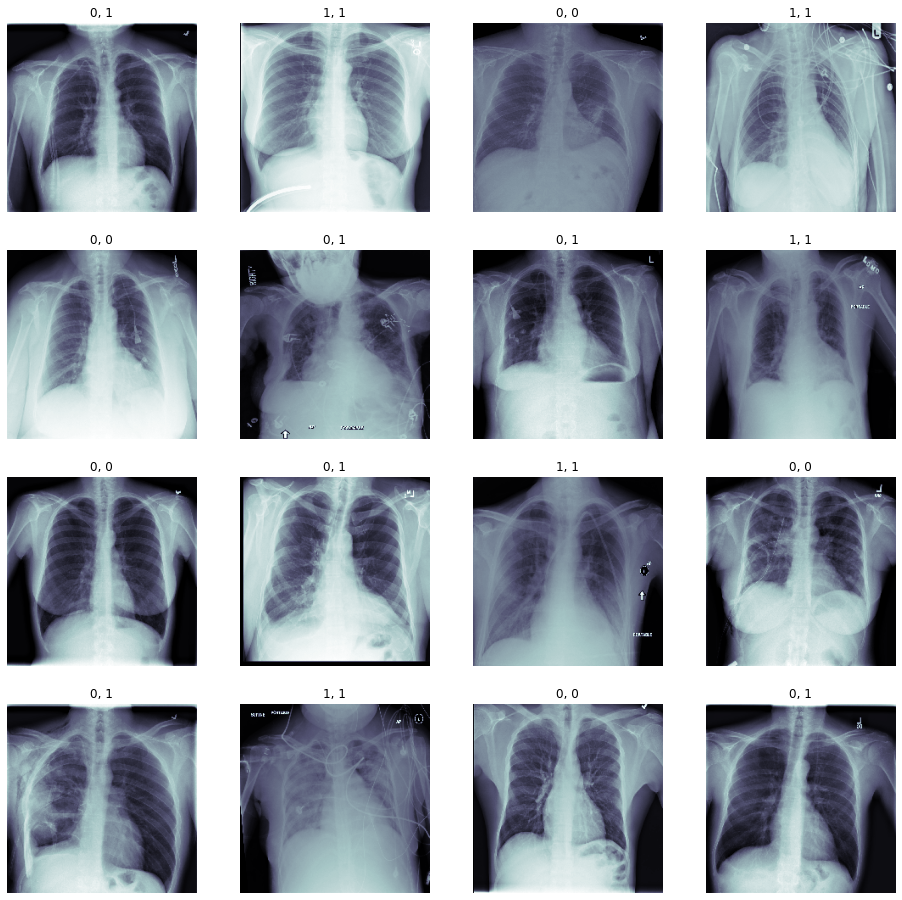

In [22]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:16], valY[0:16], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > best_thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > best_thresh:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [23]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)